# Retriever evaluation: Hybrid

Evaluate if hybrid improves on the previous results.
1. Reciprocal rerank fusion
2. Relative score fusion
3. Distribution-based score fusion

In [1]:
# Setup

import os
import textwrap as tr

import nest_asyncio
from azure.identity import DefaultAzureCredential, ManagedIdentityCredential
from azure.keyvault.secrets import SecretClient
from dotenv import load_dotenv
from llama_index.core import ServiceContext, set_global_service_context
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.core.prompts import ChatMessage, ChatPromptTemplate, MessageRole
from tqdm import tqdm

# This is a hack to get some things to work in Jupyter Notebooks
nest_asyncio.apply()

def pwrap(text):
    print(tr.fill(str(text), width=80))

# Load environment variables from .env file
try:
    load_dotenv(dotenv_path=".env")
except:
    pass

# If we're running on Azure, use the Managed Identity to get the secrets
if os.environ.get("CREDENTIAL_TYPE").lower() == "managed":
    credential = ManagedIdentityCredential()
else:
    credential = DefaultAzureCredential()

# Login to KeyVault using Azure credentials
client = SecretClient(
    vault_url=os.environ.get("AZURE_KEYVAULT_URL"), credential=credential
)

OPENAI_API_BASE = os.environ.get("AZURE_OPENAI_ENDPOINT")
OPENAI_API_VERSION = os.environ.get("AZURE_OPENAI_VERSION")
OPENAI_API_KEY = client.get_secret("OPENAI-SERVICE-KEY").value

api_key = OPENAI_API_KEY
azure_endpoint = OPENAI_API_BASE
api_version = OPENAI_API_VERSION


llm = AzureOpenAI(
    model="gpt-35-turbo",
    deployment_name="gpt-35-turbo",
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
)

# You need to deploy your own embedding model as well as your own chat completion model
embed_model = AzureOpenAIEmbedding(
    model="text-embedding-ada-002",
    deployment_name="text-embedding-ada-002",
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
)

from llama_index.core import set_global_service_context

service_context = ServiceContext.from_defaults(
    llm=llm,
    embed_model=embed_model,
)

set_global_service_context(service_context)

C:\Users\jkuehn\AppData\Local\Temp\ipykernel_45004\4010115253.py:67: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


## Generate EmbeddingQAFinetuneDataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('small_df.csv')

df.columns

Index(['section_id', 'doc_id', 'type', 'doc_title_eng', 'doc_title_fra',
       'section_str_eng', 'section_str_fra', 'heading_str_eng',
       'heading_str_fra', 'text_eng', 'text_fra', 'char_cnt_eng',
       'char_cnt_fra', 'token_cnt_eng', 'token_cnt_fra', 'text_combined_eng',
       'text_combined_fra', 'hard_eng_queries', 'easy_eng_queries',
       'easy_fra_queries', 'hard_fra_queries'],
      dtype='object')

In [3]:
from llama_index.core.evaluation import EmbeddingQAFinetuneDataset
from llama_index.core.schema import MetadataMode, TextNode
import uuid

eng_nodes = [TextNode(id=row['section_id'], text=row['text_combined_eng']) for index, row in df.iterrows()]
fra_nodes = [TextNode(id=row['section_id'], text=row['text_combined_fra']) for index, row in df.iterrows()]
eng_questions_easy = df['easy_eng_queries'].tolist()
eng_questions_hard = df['hard_eng_queries'].tolist()
fra_questions_easy = df['easy_fra_queries'].tolist()
fra_questions_hard = df['hard_fra_queries'].tolist()

def build_eval_dataset(nodes, questions):
    """Takes nodes and questions: 2 lists of the same length"""
    node_dict = {
        node.node_id: node.get_content(metadata_mode=MetadataMode.NONE)
        for node in nodes
    }
    queries = {}
    relevant_docs = {}

    for node, question in zip(nodes, questions):
        question_id = str(uuid.uuid4())
        queries[question_id] = question
        relevant_docs[question_id] = [node.node_id]

    # construct dataset
    return EmbeddingQAFinetuneDataset(
        queries=queries, corpus=node_dict, relevant_docs=relevant_docs
    )

# TODO: add multi-language corpus
# eng_to_eng_easy = build_eval_dataset(eng_nodes, eng_questions_easy)
eng_to_eng_hard = build_eval_dataset(eng_nodes, eng_questions_hard)
# fra_to_fra_easy = build_eval_dataset(fra_nodes, fra_questions_easy)
fra_to_fra_hard = build_eval_dataset(fra_nodes, fra_questions_hard)
# eng_to_fra_easy = build_eval_dataset(eng_nodes, fra_questions_easy)
# eng_to_fra_hard = build_eval_dataset(eng_nodes, fra_questions_hard)
# fra_to_eng_easy = build_eval_dataset(fra_nodes, eng_questions_easy)
# fra_to_eng_hard = build_eval_dataset(fra_nodes, eng_questions_hard)

## Define retrievers / embed documents

In [4]:
from llama_index.core import (
    SimpleDirectoryReader,
    StorageContext,
    VectorStoreIndex,
)
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.retrievers import VectorIndexRetriever

eng_storage_context = StorageContext.from_defaults()
eng_storage_context.docstore.add_documents(eng_nodes)

eng_index = VectorStoreIndex(
    nodes=eng_nodes,
    storage_context=eng_storage_context,
    show_progress=True,
)

eng_vector_retriever = VectorIndexRetriever(eng_index, similarity_top_k=5)
eng_bm25_retriever = BM25Retriever.from_defaults(nodes=eng_nodes, similarity_top_k=5)

C:\Users\jkuehn\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating embeddings: 100%|██████████| 1000/1000 [00:18<00:00, 54.89it/s]


In [6]:
fra_storage_context = StorageContext.from_defaults()
fra_storage_context.docstore.add_documents(fra_nodes)

fra_index = VectorStoreIndex(
    nodes=fra_nodes,
    storage_context=fra_storage_context,
    show_progress=True,
)

fra_vector_retriever = VectorIndexRetriever(fra_index, similarity_top_k=5)
fra_bm25_retriever = BM25Retriever.from_defaults(nodes=fra_nodes, similarity_top_k=5)

Generating embeddings:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 1000/1000 [00:58<00:00, 17.02it/s]


## Evaluate retrievers

In [7]:
from llama_index.core.evaluation import RetrieverEvaluator
from llama_index.core.retrievers import QueryFusionRetriever

import pandas as pd


def display_results(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()
    columns = {"retrievers": [name], "hit_rate": [hit_rate], "mrr": [mrr]}

    # if include_cohere_rerank:
    #     crr_relevancy = full_df["cohere_rerank_relevancy"].mean()
    #     columns.update({"cohere_rerank_relevancy": [crr_relevancy]})

    metric_df = pd.DataFrame(columns)

    return metric_df

metrics = ["mrr", "hit_rate"]

eng_rrf_retriever = QueryFusionRetriever(
    [eng_vector_retriever, eng_bm25_retriever],
    similarity_top_k=5,
    num_queries=1,  # set this to 1 to disable query generation
    mode="reciprocal_rerank",
    use_async=False,
    verbose=True,
    llm=llm,
)

fra_rrf_retriever = QueryFusionRetriever(
    [fra_vector_retriever, fra_bm25_retriever],
    similarity_top_k=5,
    num_queries=1,  # set this to 1 to disable query generation
    mode="reciprocal_rerank",
    use_async=False,
    verbose=True,
    llm=llm,
)

eng_rsf_retriever = QueryFusionRetriever(
    [eng_vector_retriever, eng_bm25_retriever],
    similarity_top_k=5,
    num_queries=1,  # set this to 1 to disable query generation
    mode="relative_score",
    use_async=False,
    verbose=True,
    llm=llm,
)

fra_rsf_retriever = QueryFusionRetriever(
    [fra_vector_retriever, fra_bm25_retriever],
    similarity_top_k=5,
    num_queries=1,  # set this to 1 to disable query generation
    mode="relative_score",
    use_async=False,
    verbose=True,
    llm=llm,
)

eng_dbs_retriever = QueryFusionRetriever(
    [eng_vector_retriever, eng_bm25_retriever],
    similarity_top_k=5,
    num_queries=1,  # set this to 1 to disable query generation
    mode="dist_based_score",
    use_async=False,
    verbose=True,
    llm=llm,
)

fra_dbs_retriever = QueryFusionRetriever(
    [fra_vector_retriever, fra_bm25_retriever],
    similarity_top_k=5,
    num_queries=1,  # set this to 1 to disable query generation
    mode="dist_based_score",
    use_async=False,
    verbose=True,
    llm=llm,
)

eng_rrf_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=eng_rrf_retriever
)
fra_rrf_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=fra_rrf_retriever
)
eng_rsf_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=eng_rsf_retriever
)
fra_rsf_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=fra_rsf_retriever
)
eng_dbs_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=eng_dbs_retriever
)
fra_dbs_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=fra_dbs_retriever
)

eng_to_eng_hard_rrf = await eng_rrf_evaluator.aevaluate_dataset(eng_to_eng_hard)
fra_to_fra_hard_rrf = await fra_rrf_evaluator.aevaluate_dataset(fra_to_fra_hard)
eng_to_eng_hard_rsf = await eng_rsf_evaluator.aevaluate_dataset(eng_to_eng_hard)
fra_to_fra_hard_rsf = await fra_rsf_evaluator.aevaluate_dataset(fra_to_fra_hard)
eng_to_eng_hard_dbs = await eng_dbs_evaluator.aevaluate_dataset(eng_to_eng_hard)
fra_to_fra_hard_dbs = await fra_dbs_evaluator.aevaluate_dataset(fra_to_fra_hard)

AttributeError: 'QueryFusionRetriever' object has no attribute 'aevaluate_dataset'

In [21]:
# result1 = display_results("eng_vector_retriever", eng_to_eng_easy_vector)
# result1["test_set"] = "eng_to_eng_easy"
# result2 = display_results("eng_bm25_retriever", eng_to_eng_easy_bm25)
# result2["test_set"] = "eng_to_eng_easy"
# result3 = display_results("eng_vector_retriever", eng_to_eng_hard_vector)
# result3["test_set"] = "eng_to_eng_hard"
# result4 = display_results("eng_bm25_retriever", eng_to_eng_hard_bm25)
# result4["test_set"] = "eng_to_eng_hard"
result1 = display_results("eng_rrf_retriever", eng_to_eng_hard_rrf)
result1["test_set"] = "eng_to_eng_hard"
result2 = display_results("eng_rsf_retriever", eng_to_eng_hard_rsf)
result2["test_set"] = "eng_to_eng_hard"
result3 = display_results("eng_dbs_retriever", eng_to_eng_hard_dbs)
result3["test_set"] = "eng_to_eng_hard"
result4 = display_results("fra_rrf_retriever", fra_to_fra_hard_rrf)
result4["test_set"] = "fra_to_fra_hard"
result5 = display_results("fra_rsf_retriever", fra_to_fra_hard_rsf)
result5["test_set"] = "fra_to_fra_hard"
result6 = display_results("fra_dbs_retriever", fra_to_fra_hard_dbs)
result6["test_set"] = "fra_to_fra_hard"

result = pd.concat([result1, result2, result3, result4, result5, result6])
result

,retrievers,hit_rate,mrr,test_set
0,eng_vector_retriever,0.999,0.985583,eng_to_eng_easy
0,eng_bm25_retriever,0.995,0.968617,eng_to_eng_easy
0,eng_vector_retriever,0.986,0.935700,eng_to_eng_hard
0,eng_bm25_retriever,0.884,0.771383,eng_to_eng_hard


In [23]:
fra_vector_retriever_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=fra_vector_retriever
)
fra_bm25_retriever_evaluator= RetrieverEvaluator.from_metric_names(
    metrics, retriever=fra_bm25_retriever
)

fra_to_fra_easy_vector = await fra_vector_retriever_evaluator.aevaluate_dataset(fra_to_fra_easy)
fra_to_fra_easy_bm25 = await fra_bm25_retriever_evaluator.aevaluate_dataset(fra_to_fra_easy)
fra_to_fra_hard_vector = await fra_vector_retriever_evaluator.aevaluate_dataset(fra_to_fra_hard)
fra_to_fra_hard_bm25 = await fra_bm25_retriever_evaluator.aevaluate_dataset(fra_to_fra_hard)

result1 = display_results("fra_vector_retriever", fra_to_fra_easy_vector)
result1["test_set"] = "fra_to_fra_easy"
result2 = display_results("fra_bm25_retriever", fra_to_fra_easy_bm25)
result2["test_set"] = "fra_to_fra_easy"
result3 = display_results("fra_vector_retriever", fra_to_fra_hard_vector)
result3["test_set"] = "fra_to_fra_hard"
result4 = display_results("fra_bm25_retriever", fra_to_fra_hard_bm25)
result4["test_set"] = "fra_to_fra_hard"

result = pd.concat([result, result1, result2, result3, result4])
result

Generating embeddings:  10%|▉         | 99/1000 [14:58<2:16:20,  9.08s/it]


,retrievers,hit_rate,mrr,test_set
0,eng_vector_retriever,0.999,0.985583,eng_to_eng_easy
0,eng_bm25_retriever,0.995,0.968617,eng_to_eng_easy
0,eng_vector_retriever,0.986,0.935700,eng_to_eng_hard
0,eng_bm25_retriever,0.884,0.771383,eng_to_eng_hard
0,fra_vector_retriever,0.995,0.983617,fra_to_fra_easy
0,fra_bm25_retriever,0.993,0.960300,fra_to_fra_easy
0,fra_vector_retriever,0.963,0.905733,fra_to_fra_hard
0,fra_bm25_retriever,0.807,0.677633,fra_to_fra_hard


In [28]:
# I named the datasets kind of backwards before, so I'm going to switch the names here

eng_to_fra_easy_bm25 = await fra_bm25_retriever_evaluator.aevaluate_dataset(fra_to_eng_easy)
eng_to_fra_hard_bm25 = await fra_bm25_retriever_evaluator.aevaluate_dataset(fra_to_eng_hard)
fra_to_eng_easy_bm25 = await eng_bm25_retriever_evaluator.aevaluate_dataset(eng_to_fra_easy)
fra_to_eng_hard_bm25 = await eng_bm25_retriever_evaluator.aevaluate_dataset(eng_to_fra_hard)

result1 = display_results("fra_bm25_retriever", eng_to_fra_easy_bm25)
result1["test_set"] = "eng_to_fra_easy"
result2 = display_results("fra_bm25_retriever", eng_to_fra_hard_bm25)
result2["test_set"] = "eng_to_fra_hard"
result3 = display_results("eng_bm25_retriever", fra_to_eng_easy_bm25)
result3["test_set"] = "fra_to_eng_easy"
result4 = display_results("eng_bm25_retriever", fra_to_eng_hard_bm25)
result4["test_set"] = "fra_to_eng_hard"

result_cross = pd.concat([result, result1, result2, result3, result4])
result_cross


,retrievers,hit_rate,mrr,test_set
0,eng_vector_retriever,0.999,0.985583,eng_to_eng_easy
0,eng_bm25_retriever,0.995,0.968617,eng_to_eng_easy
0,eng_vector_retriever,0.986,0.935700,eng_to_eng_hard
0,eng_bm25_retriever,0.884,0.771383,eng_to_eng_hard
0,fra_vector_retriever,0.995,0.983617,fra_to_fra_easy
0,fra_bm25_retriever,0.993,0.960300,fra_to_fra_easy
0,fra_vector_retriever,0.963,0.905733,fra_to_fra_hard
0,fra_bm25_retriever,0.807,0.677633,fra_to_fra_hard
0,fra_bm25_retriever,0.438,0.314800,eng_to_fra_easy
0,fra_bm25_retriever,0.266,0.187383,eng_to_fra_hard


In [31]:
eng_to_fra_easy_vector = await fra_vector_retriever_evaluator.aevaluate_dataset(fra_to_eng_easy)
eng_to_fra_hard_vector = await fra_vector_retriever_evaluator.aevaluate_dataset(fra_to_eng_hard)
fra_to_eng_easy_vector = await eng_vector_retriever_evaluator.aevaluate_dataset(eng_to_fra_easy)
fra_to_eng_hard_vector = await eng_vector_retriever_evaluator.aevaluate_dataset(eng_to_fra_hard)

result1 = display_results("fra_vector_retriever", eng_to_fra_easy_vector)
result1["test_set"] = "eng_to_fra_easy"
result2 = display_results("fra_vector_retriever", eng_to_fra_hard_vector)
result2["test_set"] = "eng_to_fra_hard"
result3 = display_results("eng_vector_retriever", fra_to_eng_easy_vector)
result3["test_set"] = "fra_to_eng_easy"
result4 = display_results("eng_vector_retriever", fra_to_eng_hard_vector)
result4["test_set"] = "fra_to_eng_hard"

result_cross = pd.concat([result_cross, result1, result2, result3, result4])

In [36]:
# Nicer labels for the results
column_mapping = {
    "retrievers": "Retriever",
    "hit_rate": "Hit Rate",
    "mrr": "Mean Reciprocal Rank",
    "test_set": "Queries",
}
value_mapping = {
    "fra_bm25_retriever": "BM25 (French)",
    "eng_bm25_retriever": "BM25 (English)",
    "fra_vector_retriever": "Vector (French)",
    "eng_vector_retriever": "Vector (English)",
    "eng_to_eng_easy": "English (Easy)",
    "eng_to_eng_hard": "English (Hard)",
    "fra_to_fra_easy": "French (Easy)",
    "fra_to_fra_hard": "French (Hard)",
    "eng_to_fra_easy": "English (Easy)",
    "eng_to_fra_hard": "English (Hard)",
    "fra_to_eng_easy": "French (Easy)",
    "fra_to_eng_hard": "French (Hard)",
}

result_cross2 = result_cross.rename(columns=column_mapping)
result_cross2 = result_cross2.replace(value_mapping)

# Split the columns so that "BM25 (French)" becomes two columns: "Retriever: BM25" and "Corpus language: French"
result_cross2["Corpus language"] = result_cross2["Retriever"].str.split(" \(").str[1].str[:-1]
result_cross2["Retriever"] = result_cross2["Retriever"].str.split(" \(").str[0]

# Split the columns so that "English (Easy)" becomes two columns: "Query language: English" and "Query difficulty: Easy"
result_cross2["Query language"] = result_cross2["Queries"].str.split(" \(").str[0]
result_cross2["Query difficulty"] = result_cross2["Queries"].str.split(" \(").str[1].str[:-1]

result_cross2 = result_cross2[
    ['Corpus language', 'Query language', 'Query difficulty', 'Retriever', 'Hit Rate', 'Mean Reciprocal Rank']
].sort_values(by=['Corpus language', 'Query language', 'Query difficulty', 'Retriever'])

result_cross2.reset_index(inplace=True, drop=True)
result_cross2

,Corpus language,Query language,Query difficulty,Retriever,Hit Rate,Mean Reciprocal Rank
0,English,English,Easy,BM25,0.995,0.968617
1,English,English,Easy,Vector,0.999,0.985583
2,English,English,Hard,BM25,0.884,0.771383
3,English,English,Hard,Vector,0.986,0.935700
4,English,French,Easy,BM25,0.136,0.053300
5,English,French,Easy,Vector,0.974,0.930783
6,English,French,Hard,BM25,0.148,0.078583
7,English,French,Hard,Vector,0.897,0.791333
8,French,English,Easy,BM25,0.438,0.314800
9,French,English,Easy,Vector,0.986,0.942900


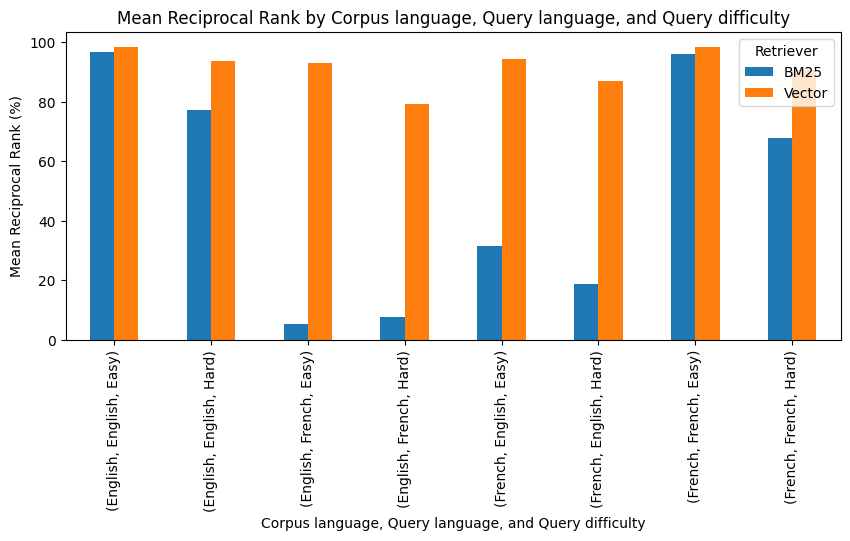

In [41]:
# Plot the MRR results as a bar chart
# Groups: Corpus language, Query language, Query difficulty
# Columns: Retriever

# Set up the data
data = result_cross2[result_cross2['Mean Reciprocal Rank'] > 0].copy()
data['Mean Reciprocal Rank'] = data['Mean Reciprocal Rank'] * 100

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 4))

# Plot the data
data.pivot_table(
    index=['Corpus language', 'Query language', 'Query difficulty'], 
    columns='Retriever', 
    values='Mean Reciprocal Rank'
).plot(kind='bar', ax=ax)

# Set the title and labels
ax.set_title('Mean Reciprocal Rank by Corpus language, Query language, and Query difficulty')
ax.set_xlabel('Corpus language, Query language, and Query difficulty')
ax.set_ylabel('Mean Reciprocal Rank (%)')

# Show the plot
plt.show()

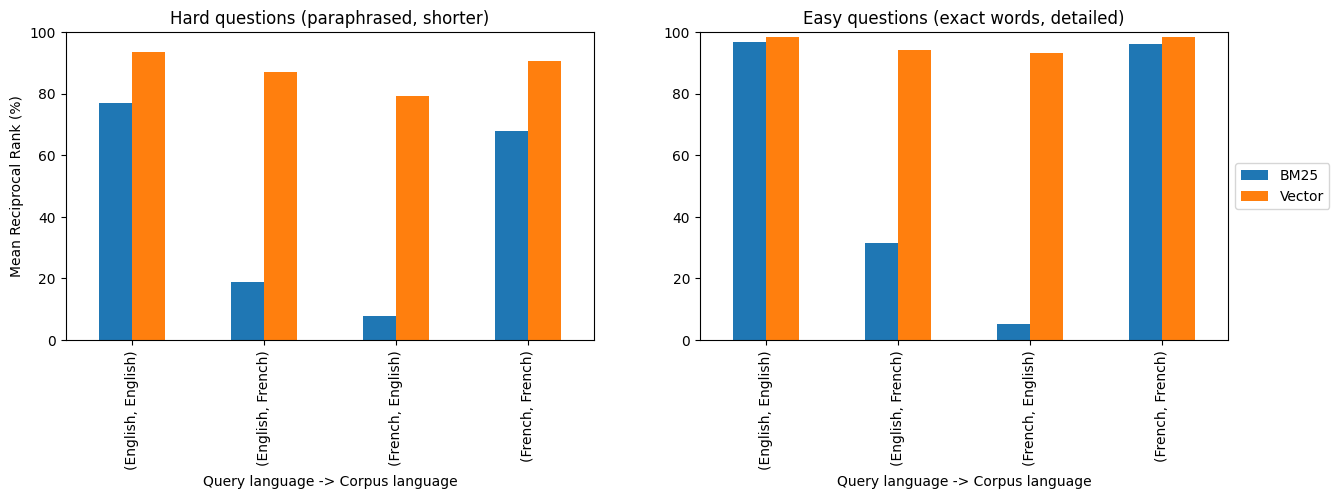

In [52]:
# Let's try that again, but separate into the Easy and Hard queries as separate dataframes
# Set up the data
data = result_cross2[result_cross2['Mean Reciprocal Rank'] > 0].copy()
data['Mean Reciprocal Rank'] = data['Mean Reciprocal Rank'] * 100

# Sort the data by MRR
data = data.sort_values(by='Mean Reciprocal Rank', ascending=False)

data_hard = data[data['Query difficulty'] == 'Hard']
data_easy = data[data['Query difficulty'] == 'Easy']

# Twin plots
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# Plot the data
data_hard.pivot_table(
    index=['Query language', 'Corpus language'], 
    columns='Retriever', 
    values='Mean Reciprocal Rank'
).plot(kind='bar', ax=ax[0])
data_easy.pivot_table(
    index=['Query language', 'Corpus language'],
    columns='Retriever', 
    values='Mean Reciprocal Rank'
).plot(kind='bar', ax=ax[1])

# Label the y-axis on the left plot
ax[0].set_ylabel('Mean Reciprocal Rank (%)')

# Set the y-axis from 0 to 100 on both plots
ax[0].set_ylim(0, 100)
ax[1].set_ylim(0, 100)

# Set the title and labels
ax[0].set_title('Hard questions (paraphrased, shorter)')
ax[0].set_xlabel('Query language -> Corpus language')

ax[1].set_title('Easy questions (exact words, detailed)')
ax[1].set_xlabel('Query language -> Corpus language')

# Move the legend outside the right plot. Remove the left legend.
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].legend().remove()

# Show the plot
plt.show()

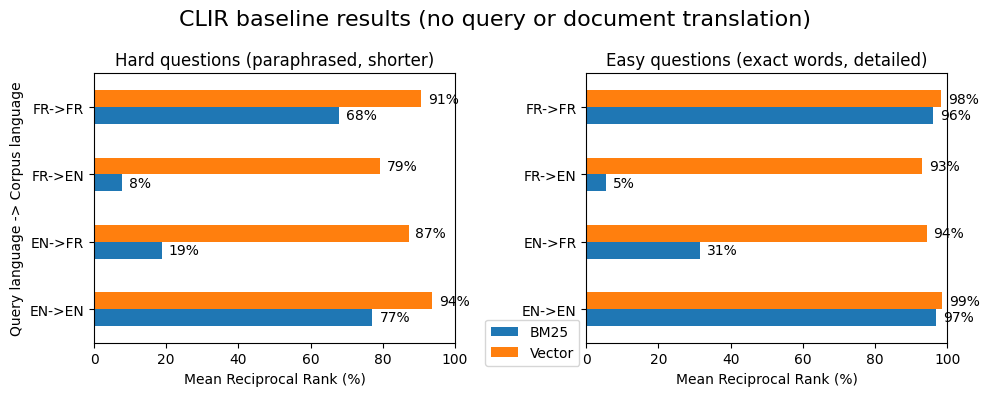

In [82]:
# Same as above but horizontal bar charts
# Twin plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot the data
data_hard.pivot_table(
    index=['Query language', 'Corpus language'], 
    columns='Retriever', 
    values='Mean Reciprocal Rank'
).plot(kind='barh', ax=ax[0])

data_easy.pivot_table(
    index=['Query language', 'Corpus language'],
    columns='Retriever', 
    values='Mean Reciprocal Rank'
).plot(kind='barh', ax=ax[1])

# Annotate each bar with the value, moving the text inside the right edge of the bar
for a in [ax[0], ax[1]]:
    for p in a.patches:
        a.annotate(
            f"{p.get_width():.0f}%",
            (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
            ha="left",
            va="center",
            xytext=(5, 0),
            textcoords="offset points",
        )

ax[0].set_xlabel('Mean Reciprocal Rank (%)')
ax[1].set_xlabel('Mean Reciprocal Rank (%)')

# Set the x-axis from 0 to 100 on both plots
ax[0].set_xlim(0, 100)
ax[1].set_xlim(0, 100)

# Set the title and labels
ax[0].set_title('Hard questions (paraphrased, shorter)')
ax[0].set_ylabel('Query language -> Corpus language')

ax[1].set_title('Easy questions (exact words, detailed)')
ax[1].set_ylabel('')

ax[0].set_yticklabels(["FR->FR", "FR->EN", "EN->FR", "EN->EN"][::-1])
ax[1].set_yticklabels(["FR->FR", "FR->EN", "EN->FR", "EN->EN"][::-1])

# Move the legend outside the right plot. Remove the left legend.
ax[1].legend(loc='center right', bbox_to_anchor=(0, 0))
ax[0].legend().remove()

# Set the overall title
fig.suptitle('CLIR baseline results (no query or document translation)', fontsize=16)
fig.tight_layout()

# Show the plot
plt.show()